In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)    

from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
data_dir = ['data/train', 'data/test']
dataset_dir = list(map(lambda x: os.path.join(config.PLASTIC_DATASET_DIR, x), data_dir))
gt_dir = ['gt/train', 'gt/test']
gt_dataset_dir = list(map(lambda x: os.path.join(config.PLASTIC_DATASET_DIR, x), gt_dir))

files = sorted(list(map(lambda x: os.path.join(dataset_dir[0], x), os.listdir(dataset_dir[0]))))

gt_files = sorted(list(map(lambda x: os.path.join(gt_dataset_dir[0], x), os.listdir(gt_dataset_dir[0]))))

# Test

In [3]:
from HySpecLab.dataset import PlasticDataset

dataset = PlasticDataset(dataset_dir[0], gt_dataset_dir[0])

100%|██████████| 4/4 [00:51<00:00, 12.99s/files]


In [4]:
from torch.utils.data import DataLoader, random_split

val_len = int(len(dataset)*0.25)
train_len = len(dataset) - val_len

train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4096, shuffle=False)

In [5]:
from HySpecLab.feature_selection.nn import KFeatureSelector

x, _ = dataset[0]

n_bands = x.size(0)
model = nn.Sequential(*[
    KFeatureSelector(n_bands, 25),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.ReLU(),
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.MSELoss()

from torch.utils.tensorboard import SummaryWriter
from HySpecLab.feature_selection.nn.utils import Reconstruction

tb_writer = SummaryWriter('runs/KFeatureSelector/MSE')
Reconstruction.train(model, optimizer, [train_loader, val_loader], 5, criterion, tb_writer=tb_writer)

100%|██████████| 5/5 [03:03<00:00, 36.69s/epoch, tls=0.0094]


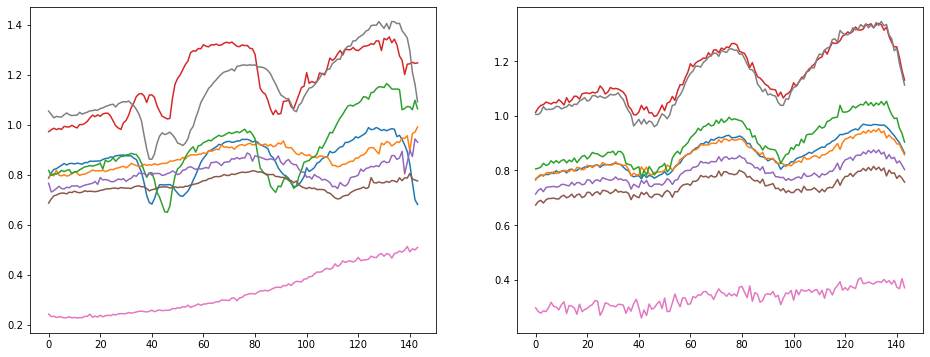

In [6]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:,None].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::512,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::512,:].T)
plt.show()

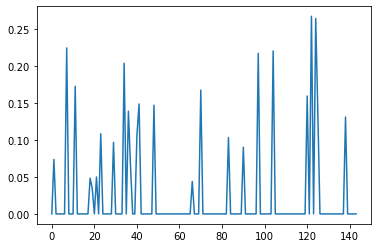

In [7]:
model.eval()
with torch.no_grad():
    input = input.to(device)
    out = model[0](input[:,:, None])
plt.plot(out[6].detach().cpu().numpy().T)
plt.show()

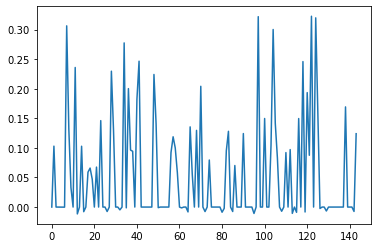

81

In [8]:
a = model[0].model[0].weight.data.cpu().flatten().numpy()
plt.plot(a)
plt.show()

len(a[a>0])

In [9]:
data = model[0].model[0].weight.data.cpu().flatten().numpy()
path = 'data/KFeatureSelector/MSE/'
if not os.path.exists(path):
    os.makedirs(path)

np.save(os.path.join(path, 'weight.npy'), data)

 # Cross-Correlation

In [ ]:
from HySpecLab.feature_selection.nn import KFeatureSelector
from HySpecLab.metrics import NCC

x, _ = dataset[0]

n_bands = x.size(0)
model = nn.Sequential(*[
    KFeatureSelector(n_bands, 25),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.ReLU(),
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = NCC()

from torch.utils.tensorboard import SummaryWriter
from HySpecLab.feature_selection.nn.utils import Reconstruction

tb_writer = SummaryWriter('runs/KFeatureSelector/NCC')
Reconstruction.train(model, optimizer, [train_loader, val_loader], 5, criterion, tb_writer=tb_writer)

In [ ]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:,None].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::512,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::512,:].T)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    input = input.to(device)
    out = model[0](input[:,:, None])
plt.plot(out[6].detach().cpu().numpy().T)
plt.show()

In [ ]:
a = model[0].model[0].weight.data.cpu().flatten().numpy()
plt.plot(a)
plt.show()

len(a[a>0])

In [ ]:
data = model[0].model[0].weight.data.cpu().flatten().numpy()
path = 'data/KFeatureSelector/NCC/'
if not os.path.exists(path):
    os.makedirs(path)

np.save(os.path.join(path, 'weight.npy'), data)

# KLDiv

In [11]:
from HySpecLab.feature_selection.nn import SparseWeightedFeatureSelector

x, _ = dataset[0]

n_bands = x.size(0)
model = nn.Sequential(*[
    SparseWeightedFeatureSelector(n_bands, 1e-5),
    nn.ReLU(),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.Sigmoid(),
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

from HySpecLab.metrics import NCC
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = NCC()

from torch.utils.tensorboard import SummaryWriter
from HySpecLab.feature_selection.nn.utils import Reconstruction

tb_writer = SummaryWriter('runs/SparseWeightedFeatureSelector/NCC')
Reconstruction.train(model, optimizer, [train_loader, val_loader], 5, criterion, tb_writer=tb_writer)

100%|██████████| 5/5 [00:20<00:00,  4.12s/epoch, tls=0.0166]


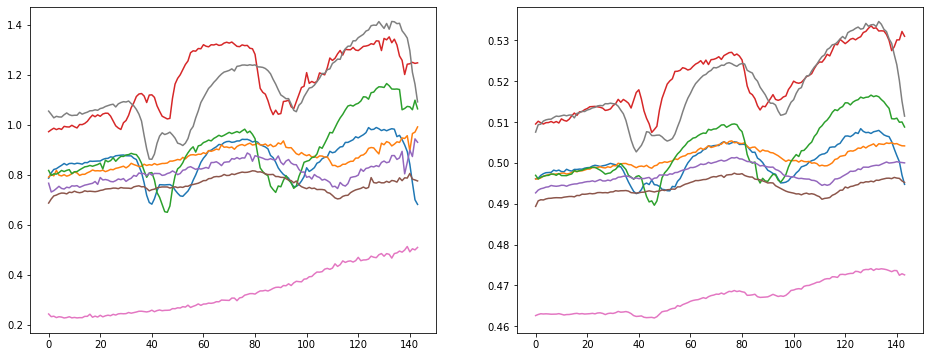

In [13]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::512,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::512,:].T)
plt.show()

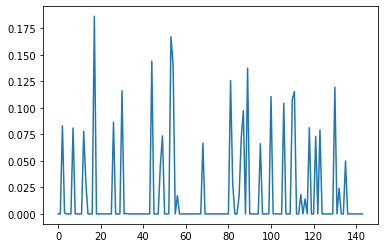

35


In [17]:
weight_data = model[0].weight.data.cpu().numpy()
weight_data_no_negative = weight_data.copy()
weight_data_no_negative[weight_data_no_negative<0] = 0
plt.plot(weight_data_no_negative)
plt.show()

print(len(weight_data[weight_data > 0]))

In [15]:
data = model[0].weight.data.cpu().numpy()
path = 'data/SparseWeightedFeatureSelector/NCC/'
if not os.path.exists(path):
    os.makedirs(path)

np.save(os.path.join(path, 'weight.npy'), data)

# KLDiv with MSE

In [18]:
from HySpecLab.feature_selection.nn import SparseWeightedFeatureSelector

x, _ = dataset[0]

n_bands = x.size(0)
model = nn.Sequential(*[
    SparseWeightedFeatureSelector(n_bands, 1e-5),
    nn.ReLU(),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.Sigmoid(),
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.MSELoss()

from torch.utils.tensorboard import SummaryWriter
from HySpecLab.feature_selection.nn.utils import Reconstruction

tb_writer = SummaryWriter('runs/SparseWeightedFeatureSelector/MSE')
Reconstruction.train(model, optimizer, [train_loader, val_loader], 5, criterion, tb_writer=tb_writer)

100%|██████████| 5/5 [00:20<00:00,  4.07s/epoch, tls=0.0143]


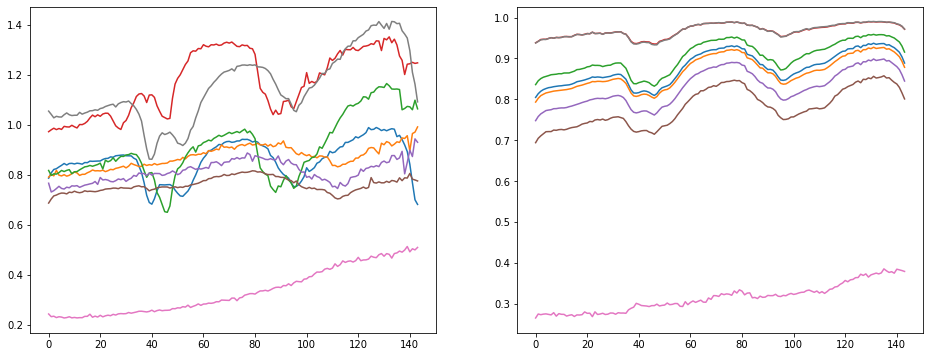

In [19]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::512,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::512,:].T)
plt.show()

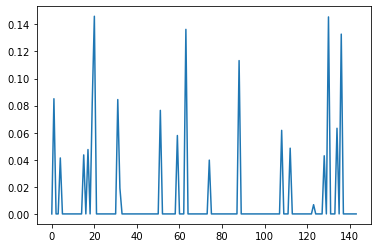

20


In [22]:
weight_data = model[0].weight.data.cpu().numpy()
weight_data_no_negative = weight_data.copy()
weight_data_no_negative[weight_data_no_negative<0] = 0
plt.plot(weight_data_no_negative)
plt.show()

print(len(weight_data[weight_data > 0]))

In [23]:
data = model[0].weight.data.cpu().numpy()
path = 'data/SparseWeightedFeatureSelector/MSE/'
if not os.path.exists(path):
    os.makedirs(path)

np.save(os.path.join(path, 'weight.npy'), data)